<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/HumanActivityGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- 데이터 로딩 ----------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/ML_Class/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/ML_Class/')
    trainy, testy = trainy - 1, testy - 1
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1968595970.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1968595970.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1968595970.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1968595970.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [2]:
# ---------- 스케일링 ----------
# 시계열 데이터를 2D로 변환 (scaler는 2차원만 입력 가능)
n_samples, n_timesteps, n_features = trainX.shape
scaler = StandardScaler()

trainX_reshaped = trainX.reshape((n_samples * n_timesteps, n_features))
testX_reshaped = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

# 표준화 적용 (각 feature 축별로 평균=0, 표준편차=1)
scaler.fit(trainX_reshaped)
trainX_scaled = scaler.transform(trainX_reshaped).reshape((n_samples, n_timesteps, n_features))
testX_scaled = scaler.transform(testX_reshaped).reshape((testX.shape[0], testX.shape[1], testX.shape[2]))

In [3]:
# ---------- Train/Validation Split ----------
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    trainX_scaled, trainy_one_hot, test_size=0.2, random_state=100
)

# ---------- GRU 모델 ----------
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

simple_gru = Sequential([
    GRU(128, input_shape=(n_timesteps, n_features)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

simple_gru.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
simple_gru.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,662 (276.02 KB)

 Trainable params: 70,662 (276.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# ---------- 학습 ----------
history = simple_gru.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4826 - loss: 1.2852 - val_accuracy: 0.8049 - val_loss: 0.5182
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8331 - loss: 0.4401 - val_accuracy: 0.9313 - val_loss: 0.1673
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9242 - loss: 0.2057 - val_accuracy: 0.8042 - val_loss: 0.6714
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9173 - loss: 0.2327 - val_accuracy: 0.9334 - val_loss: 0.1638
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9416 - loss: 0.1458 - val_accuracy: 0.9375 - val_loss: 0.1249
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9439 - loss: 0.1314 - val_accuracy: 0.9388 - val_loss: 0.1213
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9488 - loss: 0.1265 - val_accuracy: 0.9524 - val_loss: 0.1238
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9424 - loss: 0.1293 - val_accura

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9202578893790295
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       496
           1       0.97      0.95      0.96       471
           2       0.92      0.95      0.94       420
           3       0.85      0.77      0.81       491
           4       0.83      0.88      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



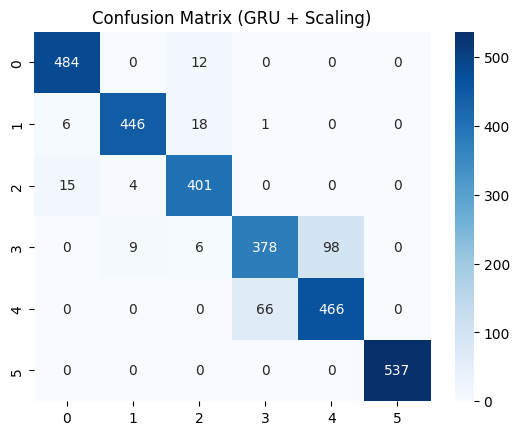

In [5]:

# ---------- 평가 ----------
pred = simple_gru.predict(testX_scaled)
pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(testy, pred)
print("Accuracy:", accuracy_score(testy, pred))
print(classification_report(testy, pred))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (GRU + Scaling)")
plt.show()
